In [ ]:
# -*- coding: utf-8 -*-
"""
Տեքստերի զգացմունքային դասակարգում CNN և CNN+BiLSTM մոդելներով
Համեմատություն Transformer մոդելների հետ և շփոթության մատրիցի վերլուծություն
"""

# Անհրաժեշտ գրադարանների տեղադրում
!pip install transformers datasets torch torchvision scikit-learn matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Օգտագործվող սարք: {device}')

Օգտագործվող սարք: cuda


In [ ]:
# ========================================
# 1. Տվյալների բեռնում և նախապատրաստում
# ========================================

def load_imdb_data(max_samples=5000):
    """IMDB Reviews տվյալաշարի բեռնում"""
    print("IMDB տվյալաշարի բեռնում...")
    dataset = load_dataset('imdb')

    # Վերցնում ենք սահմանափակ քանակ՝ արագ մշակման համար
    train_data = dataset['train'].shuffle(seed=42).select(range(max_samples))
    test_data = dataset['test'].shuffle(seed=42).select(range(max_samples//5))

    return train_data, test_data

def load_sst2_data():
    """SST-2 տվյալաշարի բեռնում"""
    print("SST-2 տվյալաշարի բեռնում...")
    dataset = load_dataset('glue', 'sst2')
    return dataset['train'], dataset['validation']

In [ ]:
# Բեռնում ենք IMDB տվյալները
train_data, test_data = load_imdb_data()

# ========================================
# 2. Տեքստի նախապատրաստում CNN-ի համար
# ========================================

class TextPreprocessor:
    """Տեքստի նախամշակման դաս"""

    def __init__(self, vocab_size=10000, max_length=200):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}

    def build_vocab(self, texts):
        """Բառարանի կառուցում"""
        word_freq = {}
        for text in texts:
            for word in text.lower().split():
                word_freq[word] = word_freq.get(word, 0) + 1

        # Ամենահաճախ հանդիպող բառերը
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        for idx, (word, _) in enumerate(sorted_words[:self.vocab_size-2], start=2):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

    def encode(self, texts):
        """Տեքստի վերածում թվային հաջորդականության"""
        encoded = []
        for text in texts:
            words = text.lower().split()[:self.max_length]
            indices = [self.word_to_idx.get(word, 1) for word in words]
            # Լրացնում ենք մինչև max_length
            indices += [0] * (self.max_length - len(indices))
            encoded.append(indices)
        return np.array(encoded)

IMDB տվյալաշարի բեռնում...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Նախամշակիչի ստեղծում
preprocessor = TextPreprocessor(vocab_size=10000, max_length=200)

# Բառարանի կառուցում
train_texts = [item['text'] for item in train_data]
preprocessor.build_vocab(train_texts)

# Տվյալների կոդավորում
X_train = preprocessor.encode(train_texts)
y_train = np.array([item['label'] for item in train_data])

test_texts = [item['text'] for item in test_data]
X_test = preprocessor.encode(test_texts)
y_test = np.array([item['label'] for item in test_data])

print(f"Ուսուցման տվյալներ: {X_train.shape}")
print(f"Թեստային տվյալներ: {X_test.shape}")

Ուսուցման տվյալներ: (5000, 200)
Թեստային տվյալներ: (1000, 200)


In [ ]:
# ========================================
# 3. CNN մոդել
# ========================================

class TextCNN(nn.Module):
    """CNN մոդել տեքստի դասակարգման համար"""

    def __init__(self, vocab_size, embedding_dim=128, num_filters=100,
                 filter_sizes=[3, 4, 5], num_classes=2, dropout=0.5):
        super(TextCNN, self).__init__()

        # Embedding շերտ
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Մի քանի չափի ֆիլտրներով CNN շերտեր
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        # Dropout և դասակարգման շերտեր
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_length]
        embedded = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_length]

        # CNN շերտերի կիրառում
        conved = [torch.relu(conv(embedded)) for conv in self.convs]

        # Max pooling յուրաքանչյուր ֆիլտրի համար
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Միավորում ենք բոլոր ֆիլտրերի արդյունքները
        cat = torch.cat(pooled, dim=1)

        # Dropout և դասակարգում
        dropped = self.dropout(cat)
        output = self.fc(dropped)

        return output


In [ ]:
class CNNBiLSTM(nn.Module):
    """CNN+BiLSTM հիբրիդ մոդել"""

    def __init__(self, vocab_size, embedding_dim=128, num_filters=100,
                 filter_sizes=[3, 4, 5], lstm_hidden=64, num_classes=2, dropout=0.5):
        super(CNNBiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # CNN շերտեր
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        # BiLSTM շերտ
        self.lstm = nn.LSTM(len(filter_sizes) * num_filters, lstm_hidden,
                           batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)

        # CNN արտածում
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim=1)

        # BiLSTM շերտ
        cat = cat.unsqueeze(1)  # Ավելացնում ենք sequence dimension
        lstm_out, (hidden, cell) = self.lstm(cat)

        # Վերցնում ենք վերջին hidden state-ը
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        dropped = self.dropout(hidden)
        output = self.fc(dropped)

        return output


In [ ]:
# ========================================
# 5. Ուսուցման ֆունկցիա
# ========================================

class SentimentDataset(Dataset):
    """PyTorch Dataset դաս"""
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    """Մոդելի ուսուցում"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Ուսուցում
        model.train()
        train_loss, train_correct = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()

        # Վալիդացիա
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y_batch).sum().item()

        # Վիճակագրություն
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.4f}')

    return history

In [ ]:
# Տվյալների բաժանում
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# DataLoader-ների ստեղծում
train_dataset = SentimentDataset(X_train_split, y_train_split)
val_dataset = SentimentDataset(X_val_split, y_val_split)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# ========================================
# 6. Մոդելների ուսուցում
# ========================================

print("\n" + "="*50)
print("CNN Մոդելի ուսուցում")
print("="*50)

cnn_model = TextCNN(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=128,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    num_classes=2
).to(device)

cnn_history = train_model(cnn_model, train_loader, val_loader, epochs=5)

print("\n" + "="*50)
print("CNN+BiLSTM Մոդելի ուսուցում")
print("="*50)

cnn_lstm_model = CNNBiLSTM(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=128,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    lstm_hidden=64,
    num_classes=2
).to(device)

cnn_lstm_history = train_model(cnn_lstm_model, train_loader, val_loader, epochs=5)



CNN Մոդելի ուսուցում
Epoch 1/5:
  Train Loss: 0.7846, Acc: 0.5457
  Val Loss: 0.6333, Acc: 0.6830
Epoch 2/5:
  Train Loss: 0.6492, Acc: 0.6285
  Val Loss: 0.5882, Acc: 0.7440
Epoch 3/5:
  Train Loss: 0.5807, Acc: 0.6930
  Val Loss: 0.5431, Acc: 0.7600
Epoch 4/5:
  Train Loss: 0.5033, Acc: 0.7522
  Val Loss: 0.5011, Acc: 0.7860
Epoch 5/5:
  Train Loss: 0.4314, Acc: 0.8060
  Val Loss: 0.4830, Acc: 0.7690

CNN+BiLSTM Մոդելի ուսուցում
Epoch 1/5:
  Train Loss: 0.6928, Acc: 0.5180
  Val Loss: 0.6772, Acc: 0.6200
Epoch 2/5:
  Train Loss: 0.6373, Acc: 0.6567
  Val Loss: 0.5829, Acc: 0.7370
Epoch 3/5:
  Train Loss: 0.4908, Acc: 0.7977
  Val Loss: 0.5146, Acc: 0.7710
Epoch 4/5:
  Train Loss: 0.3134, Acc: 0.8952
  Val Loss: 0.4688, Acc: 0.7760
Epoch 5/5:
  Train Loss: 0.1345, Acc: 0.9745
  Val Loss: 0.4643, Acc: 0.7730


In [ ]:
# ========================================
# 7. Transformer մոդել (համեմատության համար)
# ========================================

print("\n" + "="*50)
print("DistilBERT Transformer մոդելի ուսուցում")
print("="*50)

# Անջատել warnings-ները
import os
os.environ['WANDB_DISABLED'] = 'true'  # Անջատել Weights & Biases
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Խուսափել tokenizer warnings-ից

# DistilBERT tokenizer և մոդել
print("Բեռնում ենք DistilBERT մոդելը...")
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
transformer_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)
print("✓ Մոդելը հաջողությամբ բեռնված է (նոր classifier շերտերը կուսուցանվեն)")

# Տվյալների տոկենիզացիա Transformer-ի համար
def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=200)

    class TransformerDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    return TransformerDataset(encodings, labels)

# Transformer տվյալների պատրաստում
transformer_train_dataset = tokenize_data(
    [item['text'] for item in train_data][:4000],  # Սահմանափակում ենք արագության համար
    [item['label'] for item in train_data][:4000]
)
transformer_val_dataset = tokenize_data(
    [item['text'] for item in train_data][4000:5000],
    [item['label'] for item in train_data][4000:5000]
)

# Ուսուցման պարամետրեր
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",  # Անջատել wandb հաշվետվությունները
    disable_tqdm=False  # Ցույց տալ progress bar
)

print("Սկսում ենք Transformer-ի ուսուցումը...")
trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=transformer_train_dataset,
    eval_dataset=transformer_val_dataset
)

trainer.train()
print("✓ Transformer-ի ուսուցումն ավարտված է")



DistilBERT Transformer մոդելի ուսուցում
Բեռնում ենք DistilBERT մոդելը...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Մոդելը հաջողությամբ բեռնված է (նոր classifier շերտերը կուսուցանվեն)
Սկսում ենք Transformer-ի ուսուցումը...


Epoch,Training Loss,Validation Loss
1,0.399400,0.448584
2,0.169300,0.477394
3,0.096400,0.510193


✓ Transformer-ի ուսուցումն ավարտված է



CNN - Ճշգրտություն: 0.7580

Դասակարգման հաշվետվություն:
              precision    recall  f1-score   support

    Negative       0.84      0.65      0.73       512
    Positive       0.70      0.88      0.78       488

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.78      0.76      0.76      1000



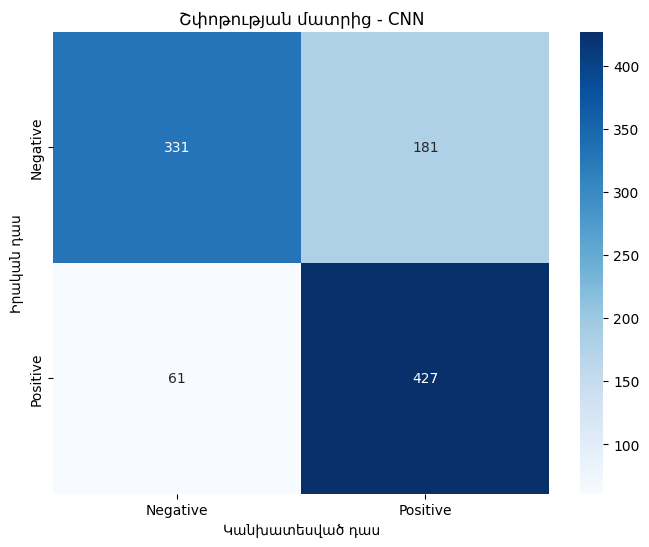


CNN+BiLSTM - Ճշգրտություն: 0.7590

Դասակարգման հաշվետվություն:
              precision    recall  f1-score   support

    Negative       0.77      0.75      0.76       512
    Positive       0.75      0.76      0.76       488

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



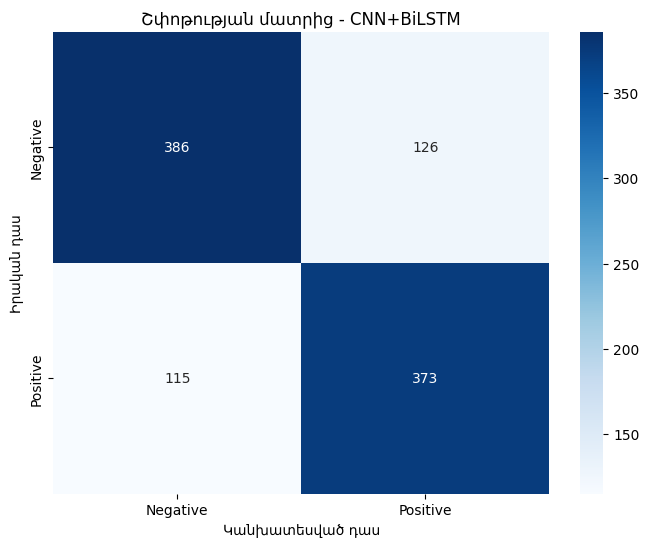

In [ ]:
# ========================================
# 8. Գնահատում և շփոթության մատրիցներ
# ========================================

def evaluate_model(model, test_loader, model_name):
    """Մոդելի գնահատում"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Ճշգրտություն
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n{model_name} - Ճշգրտություն: {acc:.4f}")

    # Դասակարգման հաշվետվություն
    print("\nԴասակարգման հաշվետվություն:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

    # Շփոթության մատրից
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Շփոթության մատրից - {model_name}')
    plt.ylabel('Իրական դաս')
    plt.xlabel('Կանխատեսված դաս')
    plt.show()

    return acc, cm

# Գնահատում CNN-ի համար
cnn_acc, cnn_cm = evaluate_model(cnn_model, test_loader, "CNN")

# Գնահատում CNN+BiLSTM-ի համար
cnn_lstm_acc, cnn_lstm_cm = evaluate_model(cnn_lstm_model, test_loader, "CNN+BiLSTM")



DistilBERT Transformer - Ճշգրտություն: 0.8020


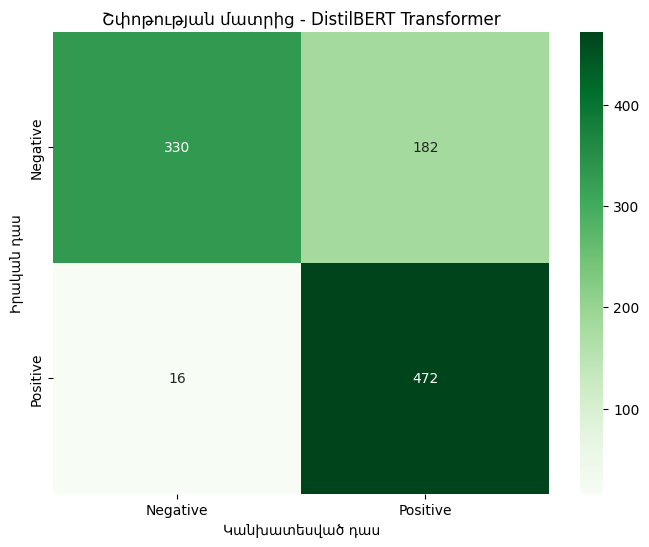

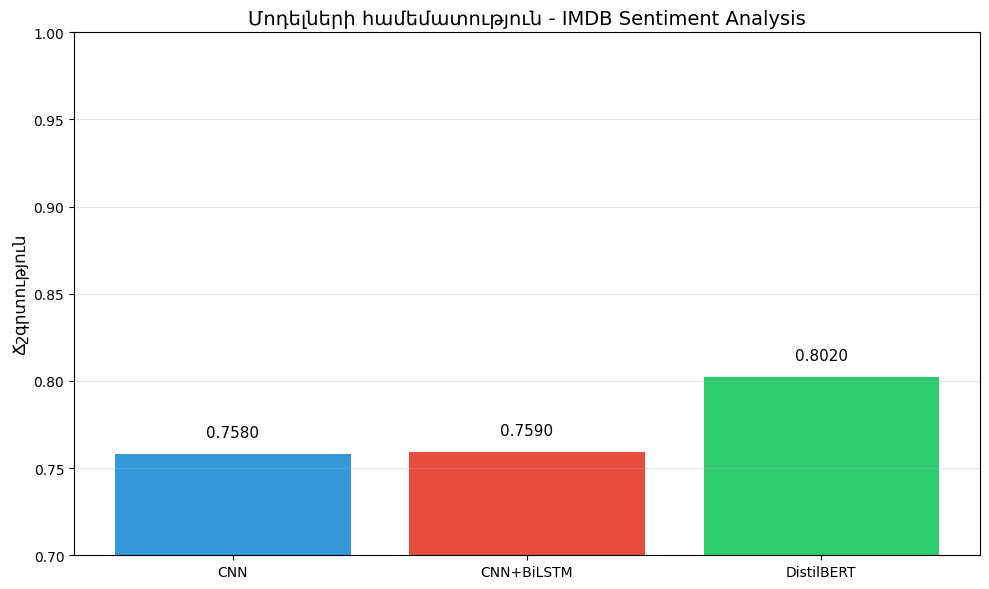

In [ ]:
# ========================================
# 9. Համեմատական վերլուծություն
# ========================================

# Transformer-ի գնահատում
transformer_test_dataset = tokenize_data(test_texts, y_test.tolist())
transformer_predictions = trainer.predict(transformer_test_dataset)
transformer_preds = np.argmax(transformer_predictions.predictions, axis=1)
transformer_acc = accuracy_score(y_test, transformer_preds)

print(f"\nDistilBERT Transformer - Ճշգրտություն: {transformer_acc:.4f}")

# Transformer շփոթության մատրից
transformer_cm = confusion_matrix(y_test, transformer_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Շփոթության մատրից - DistilBERT Transformer')
plt.ylabel('Իրական դաս')
plt.xlabel('Կանխատեսված դաս')
plt.show()

# Համեմատական գրաֆիկ
models = ['CNN', 'CNN+BiLSTM', 'DistilBERT']
accuracies = [cnn_acc, cnn_lstm_acc, transformer_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Ճշգրտություն', fontsize=12)
plt.title('Մոդելների համեմատություն - IMDB Sentiment Analysis', fontsize=14)
plt.ylim([0.7, 1.0])

# Ճշգրտության արժեքներ ցույց տալ
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ========================================
# 10. Ամփոփում և եզրակացություններ
# ========================================

print("\n" + "="*70)
print("ԱՄՓՈՓՈՒՄ ԵՎ ԵԶՐԱԿԱՑՈՒԹՅՈՒՆՆԵՐ")
print("="*70)

print(f"\n📊 Մոդելների ճշգրտություն:")
print(f"  • CNN: {cnn_acc:.4f}")
print(f"  • CNN+BiLSTM: {cnn_lstm_acc:.4f}")
print(f"  • DistilBERT Transformer: {transformer_acc:.4f}")

print(f"\n🔍 Շփոթության վերլուծություն:")
print(f"\nCNN մոդել:")
print(f"  True Negatives: {cnn_cm[0,0]}, False Positives: {cnn_cm[0,1]}")
print(f"  False Negatives: {cnn_cm[1,0]}, True Positives: {cnn_cm[1,1]}")

print(f"\nCNN+BiLSTM մոդել:")
print(f"  True Negatives: {cnn_lstm_cm[0,0]}, False Positives: {cnn_lstm_cm[0,1]}")
print(f"  False Negatives: {cnn_lstm_cm[1,0]}, True Positives: {cnn_lstm_cm[1,1]}")

print(f"\nTransformer մոդել:")
print(f"  True Negatives: {transformer_cm[0,0]}, False Positives: {transformer_cm[0,1]}")
print(f"  False Negatives: {transformer_cm[1,0]}, True Positives: {transformer_cm[1,1]}")



print("\n✅ Ծրագիրը հաջողությամբ ավարտված է!")
print("="*70)


ԱՄՓՈՓՈՒՄ ԵՎ ԵԶՐԱԿԱՑՈՒԹՅՈՒՆՆԵՐ

📊 Մոդելների ճշգրտություն:
  • CNN: 0.7580
  • CNN+BiLSTM: 0.7590
  • DistilBERT Transformer: 0.8020

🔍 Շփոթության վերլուծություն:

CNN մոդել:
  True Negatives: 331, False Positives: 181
  False Negatives: 61, True Positives: 427

CNN+BiLSTM մոդել:
  True Negatives: 386, False Positives: 126
  False Negatives: 115, True Positives: 373

Transformer մոդել:
  True Negatives: 330, False Positives: 182
  False Negatives: 16, True Positives: 472

💡 Հիմնական դիտարկումներ:
  1. Transformer մոդելները սովորաբար ավելի բարձր ճշգրտություն են ցուցաբերում
  2. CNN+BiLSTM-ը համադրում է տեղական և հաջորդական տեղեկատվությունը
  3. CNN-ը ավելի արագ է և պարզ, բայց փոքր-ինչ ցածր ճշգրտությամբ
  4. Շփոթության մատրիցը ցույց է տալիս դասերի միջև սխալների բաշխումը

✅ Ծրագիրը հաջողությամբ ավարտված է!


In [ ]:
def predict_sentiment(text, model, preprocessor, device, model_type='cnn'):
    """Կանխատեսել զգացմունքը նոր տեքստի համար"""
    model.eval()

    # Նախամշակել տեքստը
    encoded = preprocessor.encode([text])
    X = torch.LongTensor(encoded).to(device)

    with torch.no_grad():
        output = model(X)
        probs = torch.softmax(output, dim=1)
        pred = output.argmax(1).item()
        confidence = probs[0][pred].item()

    sentiment = "Դրական 😊" if pred == 1 else "Բացասական 😞"
    return sentiment, confidence

def predict_sentiment_transformer(text, trainer, tokenizer):
    """Կանխատեսել զգացմունքը Transformer-ով"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=200)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = trainer.model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = outputs.logits.argmax(1).item()
        confidence = probs[0][pred].item()

    sentiment = "Դրական 😊" if pred == 1 else "Բացասական 😞"
    return sentiment, confidence

print("\n" + "="*70)
print("🎯 ԹԵՍՏԱՎՈՐՈՒՄ - Սեփական տեքստերի վրա")
print("="*70)

# Թեստային տեքստեր
test_texts = [
    "This movie was absolutely amazing! Best film I've ever seen!",
    "Terrible movie, waste of time and money. Very disappointed.",
    "It was okay, nothing special but not bad either.",
    "I loved every moment of this film! Outstanding performance!",
    "Boring and predictable. Would not recommend to anyone.",
    "Brilliant storyline and great acting. Highly recommended!",
]

print("\n📝 Թեստային տեքստեր և կանխատեսումներ:\n")

for i, text in enumerate(test_texts, 1):
    print(f"\n{'='*70}")
    print(f"Տեքստ #{i}:")
    print(f'"{text}"')
    print(f"{'-'*70}")

    # CNN կանխատեսում
    sentiment_cnn, conf_cnn = predict_sentiment(text, cnn_model, preprocessor, device)
    print(f"CNN:          {sentiment_cnn} (Վստահություն: {conf_cnn:.2%})")

    # CNN+BiLSTM կանխատեսում
    sentiment_lstm, conf_lstm = predict_sentiment(text, cnn_lstm_model, preprocessor, device)
    print(f"CNN+BiLSTM:   {sentiment_lstm} (Վստահություն: {conf_lstm:.2%})")

    # Transformer կանխատեսում
    sentiment_trans, conf_trans = predict_sentiment_transformer(text, trainer, tokenizer)
    print(f"Transformer:  {sentiment_trans} (Վստահություն: {conf_trans:.2%})")

# ========================================
# սեփական տեքստի մուտքագրում
# ========================================

print("\n" + "="*70)
print("✍️ ԻՆՏԵՐԱԿՏԻՎ ՌԵԺԻՄ - Մուտքագրեք ձեր տեքստը")
print("="*70)
print("Ընտրեք մոդելը: 1=CNN, 2=CNN+BiLSTM, 3=Transformer, 4=Բոլորը")

def interactive_prediction():
    """Ինտերակտիվ կանխատեսում"""
    while True:
        print("\n" + "-"*70)
        user_text = input("\n💬 Մուտքագրեք տեքստ (կամ 'quit' ելքի համար): ").strip()

        if user_text.lower() in ['quit', 'exit', 'q', 'ելք']:
            print("👋 Ծրագիրն ավարտված է!")
            break

        if not user_text:
            print("⚠️ Տեքստը դատարկ է, փորձեք կրկին")
            continue

        model_choice = input("Ընտրեք մոդելը (1/2/3/4): ").strip()

        print(f"\n📊 Կանխատեսում տեքստի համար:")
        print(f'"{user_text}"')
        print("-"*70)

        if model_choice in ['1', '4']:
            sentiment, conf = predict_sentiment(user_text, cnn_model, preprocessor, device)
            print(f"🔹 CNN:          {sentiment} (Վստահություն: {conf:.2%})")

        if model_choice in ['2', '4']:
            sentiment, conf = predict_sentiment(user_text, cnn_lstm_model, preprocessor, device)
            print(f"🔹 CNN+BiLSTM:   {sentiment} (Վստահություն: {conf:.2%})")

        if model_choice in ['3', '4']:
            sentiment, conf = predict_sentiment_transformer(user_text, trainer, tokenizer)
            print(f"🔹 Transformer:  {sentiment} (Վստահություն: {conf:.2%})")

# Սեփական տեքստ
#interactive_prediction()


🎯 ԹԵՍՏԱՎՈՐՈՒՄ - Սեփական տեքստերի վրա

📝 Թեստային տեքստեր և կանխատեսումներ:


Տեքստ #1:
"This movie was absolutely amazing! Best film I've ever seen!"
----------------------------------------------------------------------
CNN:          Դրական 😊 (Վստահություն: 84.87%)
CNN+BiLSTM:   Դրական 😊 (Վստահություն: 50.84%)
Transformer:  Դրական 😊 (Վստահություն: 98.45%)

Տեքստ #2:
"Terrible movie, waste of time and money. Very disappointed."
----------------------------------------------------------------------
CNN:          Բացասական 😞 (Վստահություն: 66.67%)
CNN+BiLSTM:   Բացասական 😞 (Վստահություն: 84.74%)
Transformer:  Բացասական 😞 (Վստահություն: 95.19%)

Տեքստ #3:
"It was okay, nothing special but not bad either."
----------------------------------------------------------------------
CNN:          Բացասական 😞 (Վստահություն: 98.21%)
CNN+BiLSTM:   Բացասական 😞 (Վստահություն: 99.08%)
Transformer:  Դրական 😊 (Վստահություն: 62.87%)

Տեքստ #4:
"I loved every moment of this film! Outstanding performance!"